# Initial problem resolution

In [ ]:
using JuMP
using Gurobi, Ipopt
using CSV 
using DataFrames
using Random
using Plots
using Distributions

In [145]:
# Load time series data
load_data = CSV.read("county_demand_local_hourly_2014.csv", DataFrame)
solar_cf = CSV.read("cf_local_county_2014.csv", DataFrame)

# Load network data
bus_data = CSV.read("IEEE_33_bus_system.csv", DataFrame)
max_flows = CSV.read("max_flows.csv", DataFrame)


rename!(max_flows, "Line number" => "Branch No.")
network_data_match = all(eachrow(bus_data[!, ["From bus", "To bus", "Branch No."]]) .== eachrow(max_flows[!, ["From bus", "To bus", "Branch No."]]))

if network_data_match
    # Merge the data
    network_data = innerjoin(bus_data, max_flows, on=["From bus", "To bus", "Branch No."])
    println("Data merged successfully")
else
    println("Data columns do not match")
end

buses = 1:33
lines = 1:32
T = 48;

Data merged successfully


# First Paper


In [ ]:
# Loss power flow model -> to obtain constants
function create_hc_model_loss(network_data)
    # Initial lossless model
    model = Model(Gurobi.Optimizer)

    # Variables
    @variable(model, PG[buses] ≥ 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -0.1 <= ΔV[buses] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses])  # Voltage angle deviation
    @variable(model, PL[lines])  # Active power flow
    @variable(model, QL[lines])  # Reactive power flow
    @variable(model, PM)  # Active power exchange with upstream grid
    @variable(model, QM)  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(PG))

    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l] == g * (1) * (ΔV[i] - ΔV[j]) - b * (Δθ[i] - Δθ[j]))
        @constraint(model, QL[l] == -b * (1) * (ΔV[i] - ΔV[j]) - g * (Δθ[i] - Δθ[j]))
    end

    # Power balance constraints
    for i in buses
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] == 
            sum(network_data[l, Symbol("P (kW)")] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Convert kW to MW
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) +
            QG[i] == 
            sum(network_data[l, Symbol("Q (kW)")] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Convert kW to MW
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow <= PL[l] <= active_max_flow)
        @constraint(model, -reactive_max_flow <= QL[l] <= reactive_max_flow)
    end

    return model
end


function main_naive_loss(network_data)
    model = create_hc_model_loss(network_data)
    optimize!(model)

    # Store all solution values
    PG_values = Array(value.(model[:PG]))
    QG_values = Array(value.(model[:QG]))
    ΔV_values = Array(value.(model[:ΔV]))
    Δθ_values = Array(value.(model[:Δθ]))
    PL_values = Array(value.(model[:PL]))
    QL_values = Array(value.(model[:QL]))
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values, QG = QG_values, ΔV = ΔV_values, Δθ = Δθ_values)
    line_results = DataFrame(Line = lines, PL = PL_values, QL = QL_values)

    # Display the results
    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)

    # Print results
    println("Optimal PV capacity: ", value.(model[:PG]))
    println("Total PV capacity: ", sum(value.(model[:PG])))
    return (model, ΔV_values)
end

function optimize_naive_loss_model(network_data)
    model, ΔV_values = main_naive_loss(network_data)
    optimize!(model)
    return (model, ΔV_values)
end

# Lossless power flow model <- to feed constants
function create_hc_model_naive(network_data, ΔV_values_fixed)
    # Initial lossless model
    model = Model(Gurobi.Optimizer)

    # Variables
    @variable(model, PG[buses] ≥ 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -0.1 <= ΔV[buses] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses])  # Voltage angle deviation
    @variable(model, PL[lines])  # Active power flow
    @variable(model, QL[lines])  # Reactive power flow
    @variable(model, PM)  # Active power exchange with upstream grid
    @variable(model, QM)  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(PG))

    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l] == g * (1 + ΔV_values_fixed[i]) * (ΔV[i] - ΔV[j]) - b * (Δθ[i] - Δθ[j]))
        @constraint(model, QL[l] == -b * (1 + ΔV_values_fixed[i]) * (ΔV[i] - ΔV[j]) - g * (Δθ[i] - Δθ[j]))
    end

    # Power balance constraints
    for i in buses
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] == 
            sum(network_data[l, Symbol("P (kW)")] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Convert kW to MW
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) +
            QG[i] == 
            sum(network_data[l, Symbol("Q (kW)")] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Convert kW to MW
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow <= PL[l] <= active_max_flow)
        @constraint(model, -reactive_max_flow <= QL[l] <= reactive_max_flow)
    end

    return model
end


function main_naive(network_data, ΔV_values_fixed)
    model = create_hc_model_naive(network_data, ΔV_values_fixed)
    optimize!(model)

    # Store all solution values
    PG_values = Array(value.(model[:PG]))
    QG_values = Array(value.(model[:QG]))
    ΔV_values = Array(value.(model[:ΔV]))
    Δθ_values = Array(value.(model[:Δθ]))
    PL_values = Array(value.(model[:PL]))
    QL_values = Array(value.(model[:QL]))
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values, QG = QG_values, ΔV = ΔV_values, Δθ = Δθ_values)
    line_results = DataFrame(Line = lines, PL = PL_values, QL = QL_values)

    # Display the results
    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)

    # Print results
    println("Optimal PV capacity: ", value.(model[:PG]))
    println("Total PV capacity: ", sum(value.(model[:PG])))
end

function optimize_naive_model(network_data, ΔV_values_fixed)
    model = create_hc_model_naive(network_data, ΔV_values_fixed)
    optimize!(model)
    return model
end

function display_naive_results(model)
    # Store all solution values
    PG_values = Array(value.(model[:PG]))
    QG_values = Array(value.(model[:QG]))
    ΔV_values = Array(value.(model[:ΔV]))
    Δθ_values = Array(value.(model[:Δθ]))
    PL_values = Array(value.(model[:PL]))
    QL_values = Array(value.(model[:QL]))
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values, QG = QG_values, ΔV = ΔV_values, Δθ = Δθ_values)
    line_results = DataFrame(Line = lines, PL = PL_values, QL = QL_values)

    # Display the results
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)
    println("Total PV capacity: ", sum(PG_values[k] for k in buses))

    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
    
end

display_naive_results (generic function with 1 method)

In [284]:
# first step: get constraints
naive, ΔV_values_fixed = optimize_naive_loss_model(network_data);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 198 rows, 264 columns and 650 nonzeros
Model fingerprint: 0x1a81fabe
Coefficient statistics:
  Matrix range     [3e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [1e-02, 6e-01]
Presolve removed 155 rows and 171 columns
Presolve time: 0.00s
Presolved: 43 rows, 93 columns, 187 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7394198e+01   1.299863e+02   0.000000e+00      0s
      33    8.2340239e+00   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.234023861e+00

User-callback cal

In [ ]:
# Seoncd step: get global
naive = optimize_naive_model(network_data, ΔV_values_fixed);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 198 rows, 264 columns and 650 nonzeros
Model fingerprint: 0x751dae97
Coefficient statistics:
  Matrix range     [2e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [1e-02, 6e-01]
Presolve removed 157 rows and 174 columns
Presolve time: 0.00s
Presolved: 41 rows, 90 columns, 185 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6026642e+01   1.326068e+02   0.000000e+00      0s
      34    8.0171041e+00   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.017104121e+00

User-callback cal

A JuMP Model
├ solver: Gurobi
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 198
├ num_constraints: 297
│ ├ AffExpr in MOI.EqualTo{Float64}: 132
│ ├ AffExpr in MOI.Interval{Float64}: 66
│ ├ VariableRef in MOI.GreaterThan{Float64}: 66
│ └ VariableRef in MOI.LessThan{Float64}: 33
└ Names registered in the model
  └ :PG, :PL, :PM, :QG, :QL, :QM, :ΔV, :Δθ

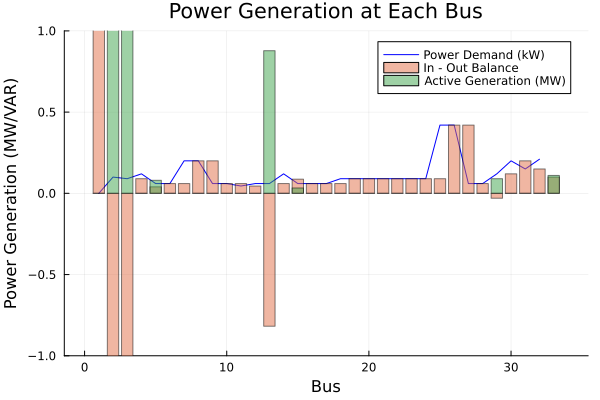

In [291]:
# Extract the results from the model
naive_PG_values = Array(value.(naive[:PG]))
# robust_PM_values = Array(value.(model_time[:PM]))

# # Calculate the line balance

line_balance = [sum([mean(Array(value.(naive[:PL]))[l]) for l in lines if network_data[l, Symbol("To bus")] == bus], init=0.0) - sum([mean(Array(value.(naive[:PL]))[l]) for l in lines if network_data[l, Symbol("From bus")] == bus], init=0.0) for bus in buses]

# # Plot the results
plot(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=1, color=:blue)
bar!(line_balance, title="Power Generation at Each Bus", xlabel="Bus", label="In - Out Balance", alpha=0.5)
bar!(naive_PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-1, 1))

In [290]:
println("Total PV capacity: ", sum(value.(naive[:PG])))

Total PV capacity: 8.017104121475056


# Robust

In [ ]:
# deprecated cell

function create_hc_model_robust_deprecated(network_data, PD_min, PD_max, QD_min, QD_max)
    model = Model(Gurobi.Optimizer)

    # Variables
    @variable(model, PG[buses] >= 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -0.1 <= ΔV[buses] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses])  # Voltage angle deviation
    @variable(model, PL[lines])  # Active power flow
    @variable(model, QL[lines])  # Reactive power flow
    @variable(model, PM)  # Active power exchange with upstream grid
    @variable(model, QM)  # Reactive power exchange with upstream grid
    @variable(model, q)  # Total PV generation

    # Objective function
    @objective(model, Max, q)  # Maximize total PV generation
    @constraint(model, q <= sum(PG[i] for i in buses))
    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l] == g * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - b * (Δθ[i] - Δθ[j]))
        @constraint(model, QL[l] == -b * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - g * (Δθ[i] - Δθ[j]))
    end

    # Power balance constraints with uncertainty
    for i in buses
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] <= sum(PD_min[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            QG[i] <= sum(QD_min[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow <= PL[l] <= active_max_flow)
        @constraint(model, -reactive_max_flow <= QL[l] <= reactive_max_flow)
    end

    return model
end

function optimize_robust_deprecated(network_data)
    # Define uncertainty sets
    PD_min = [0.8 * p for p in network_data[:, Symbol("P (kW)")]]
    PD_max = [1.2 * p for p in network_data[:, Symbol("P (kW)")]]
    QD_min = [0.8 * q for q in network_data[:, Symbol("Q (kW)")]]
    QD_max = [1.2 * q for q in network_data[:, Symbol("Q (kW)")]]
    
    model = create_hc_model_robust(network_data, PD_min, PD_max, QD_min, QD_max)
    optimize!(model)
    
    return model
end

function display_robust_results_deprecated(model)
    # Store all solution values
    PG_values = value.(model[:PG])
    QG_values = value.(model[:QG])
    ΔV_values = value.(model[:ΔV])
    Δθ_values = value.(model[:Δθ])
    PL_values = value.(model[:PL])
    QL_values = value.(model[:QL])
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Convert DenseAxisArray to regular arrays
    PG_values_array = collect(PG_values)
    QG_values_array = collect(QG_values)
    ΔV_values_array = collect(ΔV_values)
    Δθ_values_array = collect(Δθ_values)
    PL_values_array = collect(PL_values)
    QL_values_array = collect(QL_values)

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values_array, QG = QG_values_array, ΔV = ΔV_values_array, Δθ = Δθ_values_array)
    line_results = DataFrame(Line = lines, PL = PL_values_array, QL = QL_values_array)

    # Display the results
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)
    println("Total PV capacity: ", sum(PG_values_array))

    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
end

display_robust_results (generic function with 1 method)

In [256]:
function create_hc_model_robust(network_data, PD, QD)
    # Robust model using uncertainty sets for active and reactive power demand
    # PD and QD are matrices with scenarios in columns and buses in rows.
    # PD[i, j] is the active power demand at bus i in scenario j

    # Create model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 60)
    scenario = 1:size(PD, 2)
    print("Scenarios", scenario)
    # Variables
    @variable(model, PG[buses] >= 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -0.1 <= ΔV[buses, scenario] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses, scenario])  # Voltage angle deviation
    @variable(model, PL[lines, scenario])  # Active power flow
    @variable(model, QL[lines, scenario])  # Reactive power flow
    @variable(model, PM[scenario])  # Active power exchange with upstream grid
    @variable(model, QM[scenario])  # Reactive power exchange with upstream grid
    @variable(model, q)  # Total PV generation

    # Objective function
    @objective(model, Max, q)  # Maximize total PV generation
    @constraint(model, q <= sum(PG[i] for i in buses))
    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l,:] == g .* (1 .+ ΔV[i,:]) .* (ΔV[i,:] .- ΔV[j,:]) .- b .* (Δθ[i,:] .- Δθ[j,:]))
        @constraint(model, QL[l,:] == -b .* (1 .+ ΔV[i,:]) .* (ΔV[i,:] .- ΔV[j,:]) .- g .* (Δθ[i,:] .- Δθ[j,:]))
    end

    for s in scenario
        # Stochastic scenarios: equal weights for each scenario, with unique installed production for all scenarios.
        for i in buses
            @constraint(model, 
                (i == 1 ? PM[s] : 0) + 
                sum(PL[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) - 
                sum(PL[l,s] for l in lines if network_data[l, Symbol("From bus")] == i) + 
                PG[i] <= sum(PD[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
            )
            @constraint(model, 
                (i == 1 ? QM[s] : 0) + 
                sum(QL[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) - 
                sum(QL[l,s] for l in lines if network_data[l, Symbol("From bus")] == i) + 
                QG[i] <= sum(QD[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on reactive power demand
            )
        end
    end
    
    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow .<= PL[l,:] .<= active_max_flow)
        @constraint(model, -reactive_max_flow .<= QL[l,:] .<= reactive_max_flow)
    end

    return model
end

function optimize_robust(network_data, scenarios)
    # Define uncertainty sets
    PD = hcat([network_data[:, Symbol("P (kW)")] .* (0.8 .+ 0.4 .* rand(32)) for _ in 1:scenarios]...)
    QD = hcat([network_data[:, Symbol("Q (kW)")] .* (0.8 .+ 0.4 .* rand(32)) for _ in 1:scenarios]...)
    
    model = create_hc_model_robust(network_data, PD, QD)
    optimize!(model)
    
    return model
end

function display_robust_results(model)
    # Store all solution values
    PG_values = value.(model[:PG])
    QG_values = value.(model[:QG])
    ΔV_values = value.(model[:ΔV])
    Δθ_values = value.(model[:Δθ])
    PL_values = value.(model[:PL])
    QL_values = value.(model[:QL])
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Convert DenseAxisArray to regular arrays
    PG_values_array = collect(PG_values)
    QG_values_array = collect(QG_values)
    ΔV_values_array = collect(ΔV_values)
    Δθ_values_array = collect(Δθ_values)
    PL_values_array = collect(PL_values)
    QL_values_array = collect(QL_values)

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values_array, QG = QG_values_array, ΔV = ΔV_values_array, Δθ = Δθ_values_array)
    line_results = DataFrame(Line = lines, PL = PL_values_array, QL = QL_values_array)

    # Display the results
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)
    println("Total PV capacity: ", sum(PG_values_array))

    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
end

display_robust_results (generic function with 1 method)

In [257]:
robust = optimize_robust(network_data, 100)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 60
Scenarios1:100Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 13203 rows, 19867 columns and 32836 nonzeros
Model fingerprint: 0x3dd3907f
Model has 6400 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-01, 9e+00]
  QLMatrix range   [3e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [8e-03, 7e-01]
Presolve removed 10003 rows and 6835 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 6803 rows and 6835 columns
Presolve time: 0.05s
Presolved: 31100 rows, 19132 columns, 97600 nonzeros
P

A JuMP Model
├ solver: Gurobi
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 13267
├ num_constraints: 19900
│ ├ AffExpr in MOI.EqualTo{Float64}: 2
│ ├ AffExpr in MOI.LessThan{Float64}: 6601
│ ├ AffExpr in MOI.Interval{Float64}: 6600
│ ├ Vector{QuadExpr} in MOI.Zeros: 64
│ ├ VariableRef in MOI.GreaterThan{Float64}: 3333
│ └ VariableRef in MOI.LessThan{Float64}: 3300
└ Names registered in the model
  └ :PG, :PL, :PM, :QG, :QL, :QM, :q, :ΔV, :Δθ

In [292]:
robust_QG_values = Array(value.(robust[:QG]));
robust_PG_values = Array(value.(robust[:PG]));

In [255]:
line_balance = [sum([mean(Array(value.(robust[:PL])[l,:])) for l in lines][network_data[:, Symbol("To bus")] .== bus], init=0.0) - sum([mean(Array(value.(robust[:PL])[l,:])) for l in lines][network_data[:, Symbol("From bus")] .== bus], init=0.0) for bus in buses];

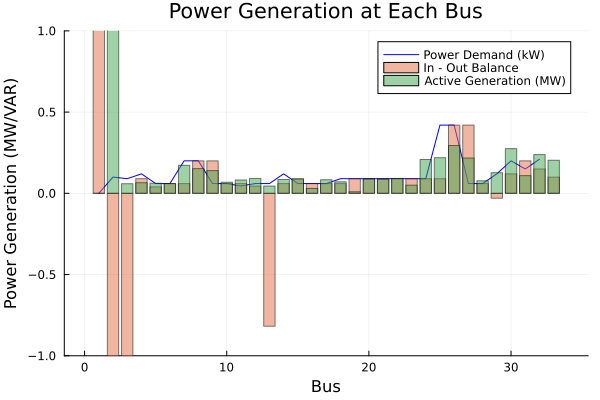

In [295]:
plot(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=1, color=:blue)

bar!(line_balance, title="Power Generation at Each Bus", xlabel="Bus", label="In - Out Balance", alpha=0.5)
bar!(robust_PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-1, 1))


# Sparse

In [62]:
function create_hc_model_robusts_sparse(network_data, PD, QD, sparsity)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 60)
    scenario = 1:size(PD, 2)
    
    # Variables
    @variable(model, PG[buses] >= 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, open_buses[buses], Bin)  # Binary variable to indicate if a bus is open
    @variable(model, -0.1 <= ΔV[buses, scenario] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses, scenario])  # Voltage angle deviation
    @variable(model, PL[lines, scenario])  # Active power flow
    @variable(model, QL[lines, scenario])  # Reactive power flow
    @variable(model, PM[scenario])  # Active power exchange with upstream grid
    @variable(model, QM[scenario])  # Reactive power exchange with upstream grid
    @variable(model, q)  # Total PV generation


    # Objective function
    @objective(model, Max, q)  # Maximize total PV generation
    @constraint(model, q <= sum(PG[i] for i in buses))
    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l,:] == g .* (1 .+ ΔV[i,:]) .* (ΔV[i,:] .- ΔV[j,:]) .- b .* (Δθ[i,:] .- Δθ[j,:]))
        @constraint(model, QL[l,:] == -b .* (1 .+ ΔV[i,:]) .* (ΔV[i,:] .- ΔV[j,:]) .- g .* (Δθ[i,:] .- Δθ[j,:]))
    end

    for s in scenario
        for i in buses
            @constraint(model, 
                (i == 1 ? PM[s] : 0) + 
                sum(PL[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) - 
                sum(PL[l,s] for l in lines if network_data[l, Symbol("From bus")] == i) + 
                PG[i] <= sum(PD[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
            )
            @constraint(model, 
                (i == 1 ? PM[s] : 0) + 
                sum(PL[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) - 
                sum(PL[l,s] for l in lines if network_data[l, Symbol("From bus")] == i) + 
                PG[i] >= sum(PD[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000-0.005  # Lower bound on active power demand
            )
            @constraint(model, 
                (i == 1 ? QM[s] : 0) + 
                sum(QL[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) - 
                sum(QL[l,s] for l in lines if network_data[l, Symbol("From bus")] == i) + 
                QG[i] <= sum(QD[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on reactive power demand
            )

            @constraint(model, 
                (i == 1 ? QM[s] : 0) + 
                sum(QL[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) - 
                sum(QL[l,s] for l in lines if network_data[l, Symbol("From bus")] == i) + 
                QG[i] >= sum(QD[l,s] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000 -0.05 # Lower bound on reactive power demand
            )
        end
    end
    
    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)
    
    @constraint(model, sum(open_buses) <= sparsity)  # Bus 1 is closed
    @constraint(model, PG .<= 10*open_buses) #Active power generation of closed buses is 0
    @constraint(model, -PG .<= 10*open_buses) #Reactive power generation of closed buses is 0

     # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow .<= PL[l,:] .<= active_max_flow)
        @constraint(model, -reactive_max_flow .<= QL[l,:] .<= reactive_max_flow)
    end
    print("Scenarios", scenario)
    return model
end

function optimize_robust_sparse(network_data, scenarios, sparse)
    # Define uncertainty sets
    PD = hcat([network_data[:, Symbol("P (kW)")] .* (0.8 .+ 0.4 .* rand(32)) for _ in 1:scenarios]...)
    QD = hcat([network_data[:, Symbol("Q (kW)")] .* (0.8 .+ 0.4 .* rand(32)) for _ in 1:scenarios]...)
    
    model = create_hc_model_robusts_sparse(network_data, PD, QD, sparse)
    optimize!(model)
    
    return model
end

optimize_robust_sparse (generic function with 1 method)

In [74]:
optimize_robust_sparse(network_data, 10, 10)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 60
Scenarios1:10Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2050 rows, 2080 columns and 5441 nonzeros
Model fingerprint: 0xa1aaf73b
Model has 640 quadratic constraints
Variable types: 2047 continuous, 33 integer (33 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  QMatrix range    [3e-01, 9e+00]
  QLMatrix range   [3e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [4e-06, 1e+01]
Presolve removed 418 rows and 685 columns
Presolve time: 0.01s
Presolved: 4102 rows, 2005 columns, 12703 nonzeros
Presolved model has 610 bilinear constraint(s)

Solv

A JuMP Model
├ solver: Gurobi
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 1420
├ num_constraints: 2840
│ ├ AffExpr in MOI.EqualTo{Float64}: 2
│ ├ AffExpr in MOI.GreaterThan{Float64}: 660
│ ├ AffExpr in MOI.LessThan{Float64}: 728
│ ├ AffExpr in MOI.Interval{Float64}: 660
│ ├ Vector{QuadExpr} in MOI.Zeros: 64
│ ├ VariableRef in MOI.GreaterThan{Float64}: 363
│ ├ VariableRef in MOI.LessThan{Float64}: 330
│ └ VariableRef in MOI.ZeroOne: 33
└ Names registered in the model
  └ :PG, :PL, :PM, :QG, :QL, :QM, :open_buses, :q, :ΔV, :Δθ

In [225]:
PG_sparse = zeros((33, 33))
for k in 1:33
    oldstd = stdout
    redirect_stdout(devnull)
    try
        robust = optimize_robust_sparse(network_data, 10, k);
        robust_PG_values = Array(value.(robust[:PG]))
    catch e
        println("Error in robust optimization with sparsity ", e)
    end
    redirect_stdout(oldstd) 
    try
        println("Sum of robust PG_values:  ", sum(robust_PG_values), " for k ", k)
    catch
        println("Error in robust optimization with sparsity ", k)
    end
    PG_sparse[k, :] = robust_PG_values
end

Sum of robust PG_values:  7.834969410928571 for k 1
Sum of robust PG_values:  7.834969410928571 for k 2
Sum of robust PG_values:  2.5316763458404448 for k 3
Sum of robust PG_values:  7.870769113776979 for k 4
Sum of robust PG_values:  7.85068015149524 for k 5
Sum of robust PG_values:  7.89299952977044 for k 6
Sum of robust PG_values:  7.740088010598439 for k 7
Sum of robust PG_values:  7.854968909446086 for k 8
Sum of robust PG_values:  7.828500696138868 for k 9
Sum of robust PG_values:  7.81653726341569 for k 10
Sum of robust PG_values:  7.882008603815934 for k 11
Sum of robust PG_values:  7.906247537178748 for k 12
Sum of robust PG_values:  7.809778168947216 for k 13
Sum of robust PG_values:  7.82888220419199 for k 14
Sum of robust PG_values:  7.807337238044548 for k 15
Sum of robust PG_values:  7.824383501747154 for k 16
Sum of robust PG_values:  7.808064966868926 for k 17
Sum of robust PG_values:  7.867743401920329 for k 18
Sum of robust PG_values:  7.911330785466975 for k 19
Sum o

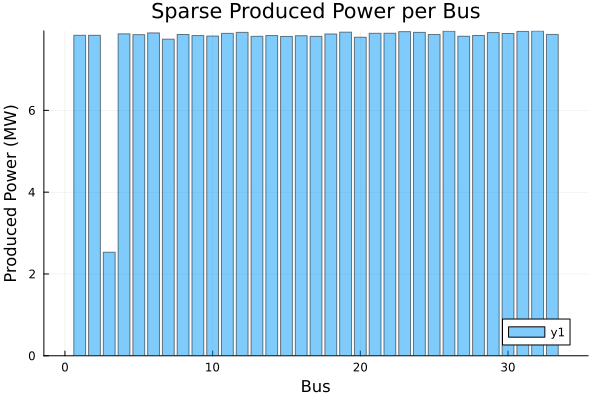

In [226]:
bar(1:33, sum(PG_sparse, dims=2), xlabel="Bus", ylabel="Produced Power (MW)", title="Sparse Produced Power per Bus", alpha=0.5)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 60
Scenarios1:10Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2050 rows, 2080 columns and 5441 nonzeros
Model fingerprint: 0x3a43b661
Model has 640 quadratic constraints
Variable types: 2047 continuous, 33 integer (33 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  QMatrix range    [3e-01, 9e+00]
  QLMatrix range   [3e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [7e-04, 5e+00]
Presolve removed 418 rows and 685 columns
Presolve time: 0.01s
Presolved: 4102 rows, 2005 columns, 12703 nonzeros
Presolved model has 610 bilinear constraint(s)

Solv

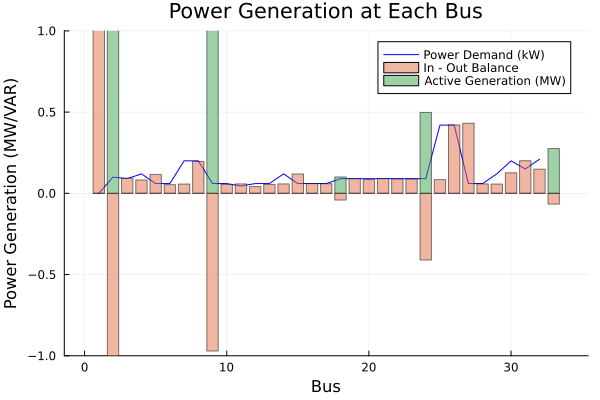

In [297]:
robust = optimize_robust_sparse(network_data, 10, 5);
robust_QG_values = Array(value.(robust[:QG]));
robust_PG_values = Array(value.(robust[:PG]));

line_balance = [sum([mean(Array(value.(robust[:PL])[l,:])) for l in lines][network_data[:, Symbol("To bus")] .== bus], init=0.0) - sum([mean(Array(value.(robust[:PL])[l,:])) for l in lines][network_data[:, Symbol("From bus")] .== bus], init=0.0) for bus in buses];

plot(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=1, color=:blue)

bar!(line_balance, title="Power Generation at Each Bus", xlabel="Bus", label="In - Out Balance", alpha=0.5)
bar!(robust_PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-1, 1))


In [298]:
println("Total PV capacity: ", sum(robust_PG_values))

Total PV capacity: 7.7935985184933045


# Stochastic Paper

In [ ]:
import Pkg; Pkg.add("Ipopt");
using Ipopt

   Resolving package versions...
   Installed MUMPS_seq_jll ────── v500.700.300+0
   Installed SPRAL_jll ────────── v2024.5.8+0
   Installed Hwloc_jll ────────── v2.11.2+1
   Installed ASL_jll ──────────── v0.1.3+0
   Installed OpenBLAS32_jll ───── v0.3.28+3
   Installed Ipopt ────────────── v1.7.0
   Installed Ipopt_jll ────────── v300.1400.1600+0
   Installed MutableArithmetics ─ v1.6.0
   Installed METIS_jll ────────── v5.1.2+1
   Installed MathOptInterface ─── v1.34.0
    Updating `C:\Users\noe\.julia\environments\Julia_v1_11_1__IAI_v3_2_2\Project.toml`
  [b6b21f68] + Ipopt v1.7.0
    Updating `C:\Users\noe\.julia\environments\Julia_v1_11_1__IAI_v3_2_2\Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + CommonSubexpressions v0.3.1
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [f6369f11] + ForwardDiff v0.10.38
  [b6b21f68] + Ipopt v1.7.0
  [1914dd2f] + MacroTools v0.5.13
  [b8f2778

In [146]:
# Lossless power flow model
function create_hc_model(load_data, solar_cf, network_data, daily_Qdemand)
    model = Model(Ipopt.Optimizer)

    # Variables
    @variable(model, PG[buses] >= 0)  # PV capacity at each bus
    @variable(model, -1 <= ΔV[buses, 1:T] <= 1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses, 1:T])  # Voltage angle deviation
    @variable(model, PL[lines, 1:T])  # Active power flow
    @variable(model, QL[lines, 1:T])  # Reactive power flow
    @variable(model, PM[1:T])  # Active power exchange with upstream grid
    @variable(model, QM[1:T])  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(PG))

    # Constraints
    # Power flow equations
    for t in 1:T, l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l,t] == g * (1 + ΔV[i,t]) * (ΔV[i,t] - ΔV[j,t]) - b * (Δθ[i,t] - Δθ[j,t]))
        @constraint(model, QL[l,t] == -b * (1 + ΔV[i,t]) * (ΔV[i,t] - ΔV[j,t]) - g * (Δθ[i,t] - Δθ[j,t]))
    end

    # Power balance constraints
    for t in 1:T, i in buses
        first_row_index = findfirst(l -> network_data[l, Symbol("To bus")] == i, lines)
        if first_row_index !== nothing
            Q_value = network_data[first_row_index, Symbol("Q (kW)")]
        else
            Q_value = 0.0  # or some default value
        end
        @constraint(model, 
            (i == 1 ? PM[t] : 0) + 
            sum(PL[l,t] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l,t] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            solar_cf[t, i+1] * PG[i] == 
            (i == 1 ? 0 : load_data[t, i+1])
        )
        @constraint(model, 
            (i == 1 ? QM[t] : 0) + 
            sum(QL[l,t] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l,t] for l in lines if network_data[l, Symbol("From bus")] == i) +
            solar_cf[t, i+1] * PG[i] == 
            (i == 1 ? 0 : Q_value) * daily_Qdemand[t] / 1000 
        )
    end

    @constraint(model, PG[1] == 0)  

    # Voltage and line capacity constraints
    for t in 1:T
        @constraint(model, -0.1 .<= ΔV[:, t] .<= 0.1)  # Voltage deviation limits
        @constraint(model, -4.6 .<= PM[t] .<= 4.6)  # Active power exchange limits with upstream grid
        for l in lines
            active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
            reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
            @constraint(model, -active_max_flow <= PL[l, t] <= active_max_flow)
            @constraint(model, -reactive_max_flow <= QL[l, t] <= reactive_max_flow)
        end
    end

    for t in nam:T-nam
        @constraint(model, (1 / nam) * sum(PM[t+h] - PM[t+h-nam] for h in 1:nam) <= NLDI_max) # Net load deviation index
    end  

    return model
end


function main(daily_Qdemand)
    model = create_hc_model(load_data, solar_cf, network_data, daily_Qdemand)
    optimize!(model)

    # Print results
    println("Optimal PV capacity: ", value.(model[:PG]))
    println("Total PV capacity: ", sum(value.(model[:PG])))
    return model
end

main (generic function with 1 method)

In [209]:
T = 72
nam = 5                 # Number of averaged measures (filter window size)
NLDI_max = 0.2 * 4.6    # Predefined upper limit

mu_PD = 0.8     # Mean daily demand
sigma_PD = 0.4  # Standard deviation

# Generate daily demand using Gaussian distribution
daily_Qdemand = clamp.(rand(Normal(mu_PD, sigma_PD), T), 0.0, 1.0)

model_time = main(daily_Qdemand)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    48003
Number of nonzeros in inequality constraint Jacobian.:     7686
Number of nonzeros in Lagrangian Hessian.............:     9216

Total number of variables............................:     9537
                     variables with only lower bounds:       33
                variables with lower and upper bounds:     2376
                     variables with only upper bounds:        0
Total number of equality constraints.................:     9361
Total number of inequality constraints...............:     7119
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     7056
        inequality constraints with only upper bounds:       63

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2999967e-01 6.34e-01 5.63e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

A JuMP Model
├ solver: Ipopt
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 9537
├ num_constraints: 21265
│ ├ AffExpr in MOI.EqualTo{Float64}: 4753
│ ├ AffExpr in MOI.LessThan{Float64}: 63
│ ├ AffExpr in MOI.Interval{Float64}: 7056
│ ├ QuadExpr in MOI.EqualTo{Float64}: 4608
│ ├ VariableRef in MOI.GreaterThan{Float64}: 2409
│ └ VariableRef in MOI.LessThan{Float64}: 2376
└ Names registered in the model
  └ :PG, :PL, :PM, :QL, :QM, :ΔV, :Δθ

In [167]:
# Some data processing to scale columns of load_data
for bus in 1:33
    load_data[:, bus+1] = load_data[:, bus+1] ./ mean(load_data[:, bus+1]) .* network_data[bus, Symbol("P (kW)")] / 1000
end

BoundsError: BoundsError: attempt to access 32×9 DataFrame at index [33, Symbol("P (kW)")]

In [212]:
bus = 4
mean(load_data[1:T, bus+1]), network_data[bus, Symbol("P (kW)")] / 1000

(0.1603875034609227, 0.12)

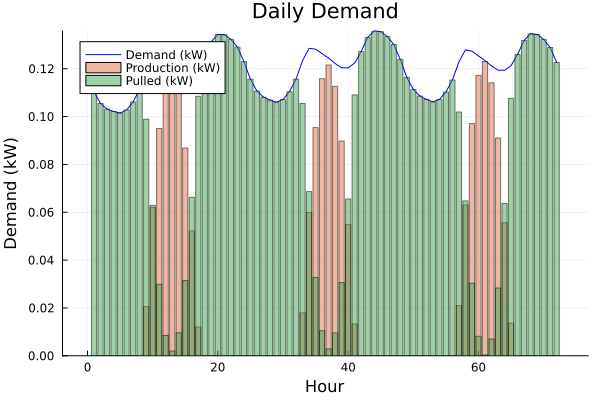

In [ ]:
# For bus i
bus = 3
load_data_b = load_data[1:T, bus+1]
solar_cf_b = solar_cf[1:T, bus+1]
prod_b = solar_cf_b * value.(model_time[:PG])[bus]
pulled_b = [sum([value.(model_time[:PL])[l,t] for l in lines if network_data[l, Symbol("To bus")] == bus], init=0.0) - sum([value.(model_time[:PL])[l,t] for l in lines if network_data[l, Symbol("From bus")] == bus], init=0.0) for t in 1:T]
plot(1:T, load_data_b, title="Daily Demand", xlabel="Hour", ylabel="Demand (kW)", label="Demand (kW)", alpha=1, color=:blue)
bar!(1:T, prod_b, label="Production (kW)", alpha=0.5)
bar!(1:T, pulled_b, label="Pulled (kW)", alpha=0.5)

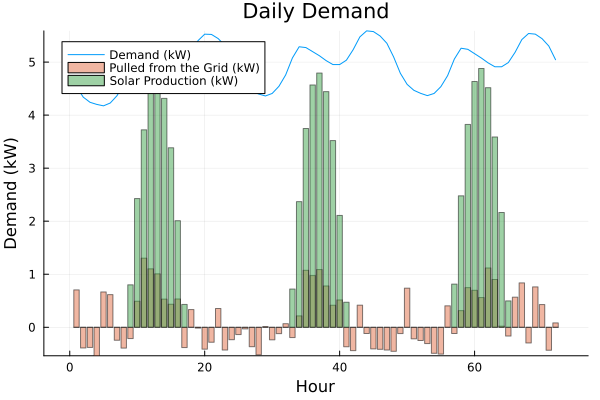

In [219]:
given_t = Array(value.(model_time[:PM]))

load_t = [sum(load_data[t, i+1] for i in 1:33) for t in 1:T]
daily_solar = Matrix(solar_cf[1:T, 1 .+ buses])

plot(1:T, load_t, title="Daily Demand", xlabel="Hour", ylabel="Demand (kW)", label="Demand (kW)")

bar!(1:T, given_t, title="Daily Demand", xlabel="Hour", ylabel="Demand (kW)", label="Pulled from the Grid (kW)", alpha=0.5)
bar!(1:T, sum(solar_cf[1:T, bus+1] * value.(model_time[:PG])[bus] for bus in 1:33) , title="Daily Demand", xlabel="Hour", ylabel="Demand (kW)", label="Solar Production (kW)", alpha=0.5)
# plot!(1:T, load_t, title="Daily Demand", xlabel="Hour", ylabel="Demand (kW)", label="Demand (kW)", alpha=1)

In [ ]:
println("Total PV capacity: ", sum(value.(model_time[:PG])))

Total PV capacity: 8.611929025524613
